<h1>Evolving the StarCraftII Build Order Meta</h1>

<h2>Introduction</h2>
Google's Artificial Intelligence research group, [DeepMind](https://deepmind.com/) recently released a python API, [pySC2](https://github.com/deepmind/pysc2) for the popular Real Time Strategy (RTS) computer game, [StarCraftII](http://us.battle.net/sc2/en/). After successfully conquering the boardgame, Go, with their AlphaGo program, [DeepMind has set their sights](https://deepmind.com/blog/deepmind-and-blizzard-open-starcraft-ii-ai-research-environment/) on the next big challenge for AI systems in attempting to train these systems to learn how to compete with world champions in the increadibly complex world of StarCraft. In this post, we use the pySC2 API to collect gameplay data from replays of human played games with the aim of discoverying some macro elements of the game, such as the different technology progression trees players use. Ultimately, the hope is to build up some intuition on what data is availible from the pySC2 API and how it might be useful in building systems capable of playing the game, but that work will be outside the scope of this post. For now we aim to discover the order of technology and units built by professional players, and how those build orders change depending on what players learn about the build order of their opponent.

<h3>StarCraftII</h3>
StarCrafII is a Real Time Strategy game where players compete against each other on a game map by building an army of units to defeat the opponents army of units and associated buildings. Players need to construct buildings from gathered resources that allow them to create new units and buildings that advance the technology of the player to build stronger units. Each player has many options for how they wish to advance their technology tree, made more complex by the existance of 3 races (Terran, Protoss and Zerg) a player can select from with each having unique units, buildings and technology advancements. Different technologies are better at defeating certain units of the opposing players, but each player can only see the technology advancement of their opponent by using units to search across the map to see what the oppenent is doing and to learn how best to adapt their technology advancement against what their opponent is building.

<h3>Dataset</h3>
The dataset was collected using the pySC2 API from replays released by Blizzard Entertainment for version 3.16.1 of the game. The data is only taken from replays of Platinum players (MMR > 3440) and only utilizes the feature layers exposed by the API. The final dataset contains 3014 replays, with half being from player1's persepective and the other half from player2's persepective of the same replay. The state of the game for each replay was taken every 1 second and saved into a state data list with the following elements at each index, with a total of XXX states in the dataset.

State Data:  
0: replay_id  
1: map_name  
2: player_id  
3: minimap  
4: friendly_army  
5: enemy_army  
6: player (resource data)  
7: availible_actions  
8: taken actions  
9: winner  
10: race  
11: enemy race

Index 3 of the state data tuple is a minimap tuple containing the following data:

minimap:  
0: creep  
1: camera  
2: player_id  
3: player_relative  
4: power  
5: friendly army density  
6: most common friendly unit  
7: total friendly HP and shields  
8: enemy army density  
9: most common enemy unit  
10: total enemy HP and shields

<h2>BuildRecommender Class</h2>
To perform the analysis, we have a helper class that abstracts away the data-munging and machine-learning tasks we'll be utilizing. The class became a bit of a behemoth and could probably use some refactoring, but it has everything we need to load up the data, transform it, train the RNN model and evolve its hyperparameters and finally make the build predictions we're after.

In [45]:
import os
import numpy as np
import json
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import random
from deap import base, creator, tools
import math
import dask.array as da
from tensorflow.python.framework import graph_util

class EarlyStoppingCallback(tflearn.callbacks.Callback):
    def __init__(self, max_val_loss_delta):
        self.best_val_loss = math.inf
        self.max_val_loss_delta = max_val_loss_delta
    
    def on_epoch_end(self, training_state):
        """ 
        This is the final method called in trainer.py in the epoch loop. 
        We can stop training and leave without losing any information with a simple exception.  
        """
        self.best_val_loss = min(training_state.val_loss,self.best_val_loss)
        if (training_state.val_loss - self.best_val_loss) >= self.best_val_loss*self.max_val_loss_delta:
            print("Terminating training at the end of epoch", training_state.epoch)
            print("Epoch loss = %s vs best loss = %s" %(training_state.val_loss, self.best_val_loss))
            raise StopIteration      
    
    def on_train_end(self, training_state):
        """
        Furthermore, tflearn will then immediately call this method after we terminate training, 
        (or when training ends regardless). This would be a good time to store any additional 
        information that tflearn doesn't store already.
        """
        print("Successfully left training! Final model loss:", training_state.val_loss)
       
        
class BuildRecommender():

    """

    """

    def __init__(self, replay_data_dir=None,build_order_file=None,load_graph_file=None):
        self.replay_data_dir = replay_data_dir
        self.build_order_file = build_order_file
        self.unit_ids = self.load_unit_ids()
        self.vocab = []
        self.max_seq_len = 0
        self.X = []
        self.y = []
        self.best_model_score = -math.inf
        self.best_ind = None
        self.model = None
        self.race_units = {'Terran':[],'Zerg':[],'Protoss':[]}
        if load_graph_file:
            self.graph = self.load_graph(load_graph_file)
        else:
            self.graph = None     

    def load_unit_ids(self):
        with open("unit_ids.json") as infile:
            unit_ids = json.load(infile)
            unit_ids = {int(unit_id):name for unit_id,name in unit_ids.items()}
        return unit_ids

    def yield_replay_data(self):
        for root, dirs, files in os.walk(self.replay_data_dir):
            for name in files:
                with open(self.replay_data_dir + "/" + name) as infile:
                    try:
                        replay_data = [json.loads(line) for line in infile]
                        yield replay_data
                    except ValueError:
                        print("Replay %s load failed" %(name))
                        
    def get_replay_build_order(self,replay_data):
        build_order = []
        friendly_build = []
        enemy_build = []
        for state in replay_data:
            state_build = []
            for unit_data in state[4]:
                if unit_data[1] > 0:
                    unit = self.unit_ids[unit_data[0]]
                    
                    if unit not in friendly_build:
                        friendly_build.append(unit)
                        state_build = state_build + [unit + str(0)]
            for unit_data in state[5]:
                if unit_data[1] > 0:
                    unit = self.unit_ids[unit_data[0]]
                    if unit not in enemy_build:
                        enemy_build.append(unit)
                        state_build = state_build + [unit + str(1)]
            if state_build:
                build_order = build_order + state_build
        player_id = replay_data[0][2]
        winner = replay_data[0][9]
        if player_id == winner:
            won = True
        else:
            won = False
        race = replay_data[0][10]
        enemy_race = replay_data[0][11]
        game_map = replay_data[0][1]
        replay_id = replay_data[0][0]
        build_data = [build_order,won,race,enemy_race,game_map,replay_id]
        return build_data        
       
    def save_all_build_orders(self):
        #clear save file is exists
        with open(self.build_order_file, 'w') as outfile: pass
        for replay_data in self.yield_replay_data():
            build_order = self.get_replay_build_order(replay_data)
            with open(self.build_order_file, 'a') as outfile:
                json.dump(build_order,outfile)
                outfile.write('\n')
    
    def load_all_build_orders(self):
        build_orders = []
        with open(self.build_order_file,'r') as infile:
            for line in infile:
                build_data = json.loads(line)
                self.max_seq_len = max(self.max_seq_len,len(build_data[0])-1)
                build_orders.append(build_data)
                races = [build_data[2],build_data[3]]
                for build in build_data[0]:
                    unit = build[0:-1]
                    player = int(build[-1])
                    if build not in self.vocab:
                        self.vocab.append(build)
                    if unit not in self.race_units[races[player]]:
                        self.race_units[races[player]].append(unit)          
        return build_orders

    def make_training_data(self,downsample=0.15):
        self.X = []
        self.y = []
        if not self.vocab:
            self.load_all_build_orders()
        with open(self.build_order_file,'r') as infile:
            for line in infile:
                if random.random() <= downsample:
                    build_order = json.loads(line)[0]
                    for i in range(len(build_order)-1):
                        self.X.append([self.vocab.index(unit) for unit in build_order[0:i+1]])
                        self.y.append(self.vocab.index(build_order[i+1]))
        return self.X, self.y

    def decode_individual(self,individual):
        arch = round(individual[0])
        n_units = int(individual[1]*256)
        dropout = individual[2]*.9
        learning_rate = individual[3]/100
        hyperparams = [arch,n_units,dropout,learning_rate]
        return hyperparams

    def evaluate(self,individual):
        hyperparams = self.decode_individual(individual)
        model = self.train(hyperparams)
        model_score = model.evaluate(self.testX, self.testY)
        if model_score[0] > self.best_model_score:
            self.model = model
            self.best_model_score = model_score[0]
            self.best_ind = individual
            self.freeze_graph()
        print("Model score = %s" %(model_score))
        return model_score
    
    def pred_preprocessing(self,pred_input):
        X = [[self.vocab.index(unit) for unit in pred_input]]
        X = pad_sequences(X, maxlen=self.max_seq_len, value=0.,padding='post')
        return X

    def preprocessing(self,X,y):
        trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=42)
        # Sequence padding
        trainX = pad_sequences(trainX, maxlen=self.max_seq_len, value=0.,padding='post')
        testX = pad_sequences(testX, maxlen=self.max_seq_len, value=0.,padding='post')
        
        chunks = 10
        trainX = da.from_array(np.asarray(trainX), chunks=chunks)
        trainY = da.from_array(np.asarray(trainY), chunks=chunks)
        testX = da.from_array(np.asarray(testX), chunks=chunks)
        testY = da.from_array(np.asarray(testY), chunks=chunks)

        # Converting labels to binary vectors
        trainY = to_categorical(trainY, nb_classes=len(self.vocab))
        testY = to_categorical(testY, nb_classes=len(self.vocab))
        return trainX, testX, trainY, testY   

    def train(self, hyperparams):
        #reset graph from previously trained iterations
        tf.reset_default_graph()
        if self.X == []:
            self.make_training_data()
        
        self.trainX, self.testX, self.trainY, self.testY = self.preprocessing(self.X,self.y)    

        # Hyperparameters
        num_epochs = 50
        arch,n_units,dropout,learning_rate = hyperparams

        # Network building
        net = tflearn.input_data([None, self.max_seq_len])
        net = tflearn.embedding(net, input_dim=len(self.vocab), output_dim=128,trainable=True)
        if arch == 0:
            net = tflearn.lstm(net, n_units=n_units,
                               dropout=dropout,
                               weights_init=tflearn.initializations.xavier(),return_seq=False)
        else:
            net = tflearn.gru(net, n_units=n_units,
                              dropout=dropout,
                              weights_init=tflearn.initializations.xavier(),return_seq=False)
        net = tflearn.fully_connected(net, len(self.vocab), activation='softmax',
                                      weights_init=tflearn.initializations.xavier())
        net = tflearn.regression(net, optimizer='adam', learning_rate=learning_rate,
                                 loss='categorical_crossentropy')
        model = tflearn.DNN(net, tensorboard_verbose=2,
                            tensorboard_dir='C:/Users/macle/Desktop/Open Source Projects/autocraft/EDA/tensorboard')       

        # Training
        early_stopping_cb = EarlyStoppingCallback(max_val_loss_delta=0.01)
        #Need to catch early stopping to return model
        try:
            model.fit(self.trainX, self.trainY, validation_set=(self.testX, self.testY), show_metric=False,snapshot_epoch=True,
                      batch_size=128,n_epoch=num_epochs,run_id="%s-%s-%s-%s" %(arch,n_units,dropout,learning_rate),
                      callbacks=early_stopping_cb)
            return model
        except StopIteration:
            return model
   
    def evolve(self,n_pop,co_prob,mut_prob,n_generations):

        #Setup fitness (maximize val_loss)
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        #Individual represented as list of 4 floats 
        #(lstm/gru,n_units,dropout,learning_rate)
        #floats are later decoded to appropriate sizes
        #for each hyperparamter

        IND_SIZE=4
        creator.create("Individual", list, fitness=creator.FitnessMax)

        toolbox = base.Toolbox()
        toolbox.register("attr_float", random.random)
        toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_float, n=IND_SIZE)

        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        toolbox.register("evaluate", self.evaluate)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)

        pop = toolbox.population(n=n_pop)
        best_ind = pop[0]
        best_fit = -math.inf

        # Evaluate the entire population
        fitnesses = map(toolbox.evaluate, pop)
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        for g in range(n_generations):
            print("Running generation %s" %(g))
            # Select the next generation individuals
            offspring = toolbox.select(pop, len(pop))
            # Clone the selected individuals
            offspring = list(map(toolbox.clone, offspring))

            # Apply crossover and mutation on the offspring
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < co_prob:
                    toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < mut_prob:
                    toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
                #keep the single best perfoming ind through all gens
                if fit[0] > best_fit:
                    best_ind = ind
                    best_fit = fit[0]

            # The population is entirely replaced by the offspring
            pop[:] = offspring
            
        return best_ind, pop
    
    def freeze_graph(self):
        # We precise the file fullname of our freezed graph
        output_graph = "C:/Users/macle/Desktop/Open Source Projects/autocraft/webapp/model/model.pb"

        # Before exporting our graph, we need to precise what is our output node
        # This is how TF decides what part of the Graph he has to keep and what part it can dump
        # NOTE: this variable is plural, because you can have multiple output nodes
        output_node_names = "InputData/X,FullyConnected/Softmax"

        # We clear devices to allow TensorFlow to control on which device it will load operations
        clear_devices = True

        # We import the meta graph and retrieve a Saver
        #saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We retrieve the protobuf graph definition
        graph = self.model.net.graph
        input_graph_def = graph.as_graph_def()

        # We start a session and restore the graph weights
        # We use a built-in TF helper to export variables to constants
        sess = self.model.session
        output_graph_def = graph_util.convert_variables_to_constants(
            sess, # The session is used to retrieve the weights
            input_graph_def, # The graph_def is used to retrieve the nodes 
            output_node_names.split(",") # The output node names are used to select the usefull nodes
        ) 

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
        print("%d ops in the final graph." % len(output_graph_def.node))
    
    def load_graph(self):
        # We load the protobuf file from the disk and parse it to retrieve the 
        # unserialized graph_def
        with tf.gfile.GFile("C:/Users/macle/Desktop/Open Source Projects/autocraft/webapp/model/model.pb", "rb") as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())

        # Then, we can use again a convenient built-in function to import a graph_def into the 
        # current default Graph
        with tf.Graph().as_default() as graph:
            tf.import_graph_def(
                graph_def, 
                input_map=None, 
                return_elements=None, 
                name="prefix", 
                op_dict=None, 
                producer_op_list=None
            )
        self.graph = graph
        return graph
    
    def predict(self,pred_input):
        if not self.graph:
            self.freeze_graph()
            self.load_graph()
        pred_input = self.pred_preprocessing(pred_input)
        x = self.graph.get_tensor_by_name('prefix/InputData/X:0')
        y = self.graph.get_tensor_by_name("prefix/FullyConnected/Softmax:0")
        with tf.Session(graph=self.graph) as sess:
            build_probs = sess.run(y, feed_dict={
                x: pred_input
            })
        return build_probs
    
    def recurse_predictions(self,pred_input,preds,races,copy_vocab):
        rec_build = np.argmax(preds[0])
        rec = copy_vocab[rec_build]
        unit = rec[0:-1]
        player = int(rec[-1])
        if rec not in pred_input and unit in self.race_units[races[player]]:
            return rec
        else:
            preds = np.delete(preds,rec_build)
            copy_vocab.pop(rec_build)
            return self.recurse_predictions(pred_input,preds,races,copy_vocab)       
    
    def predict_build(self,pred_input,build_length,races):
        #using list creates copy
        copy_vocab = list(self.vocab)
        for i in range(build_length):
            build_probs = self.predict(pred_input)
            rec = self.recurse_predictions(pred_input,build_probs,races,copy_vocab)
            pred_input.append(rec)
        return pred_input    

<h2>Exploratory Data Analysis</h2>
Before jumping right into building a model, lets explore the build order data, building visualizations to view common builds and get a sense of the dataset.

<h3>Build Data</h3>
We can use the data loader to collect the build order data we have. The data has been parsed into a 6-tuple of [build_order,won,race,enemy_race,map,replay_id] where build order is a list of uniquely seen buildings and units in order of sighting by the players perspective. Builds/units are marked with a trailing 0 or 1 to indicate if the unit is the player's(0) or the opponent's(1). Won indicates whether the player won the match or not.

In [20]:
#parse and save build data to file
builder = BuildRecommender("replay_state_data",'build_orders.json')
#builder.save_all_build_orders()
all_builds = builder.load_all_build_orders()
print("%s replays collected" %(len(all_builds)))
#example build_data
all_builds[0]

25115 replays collected


[['Nexus0',
  'Probe0',
  'Pylon0',
  'Gateway0',
  'Assimilator0',
  'Hatchery1',
  'SpawningPool1',
  'Egg1',
  'Drone1',
  'Extractor1',
  'CyberneticsCore0',
  'Overlord1',
  'Stargate0',
  'Adept0',
  'AdeptPhaseShift0',
  'Zergling1',
  'Oracle0',
  'WarpGate0',
  'Queen1',
  'CreepTumor1',
  'Zealot0',
  'Larva1',
  'SporeCrawler1',
  'Sentry0',
  'TwilightCouncil0',
  'Forge0',
  'MothershipCore0',
  'Phoenix0',
  'RoboticsFacility0',
  'OracleStasisTrap0',
  'Overseer1',
  'TemplarArchive0',
  'Lair1',
  'PhotonCannon0',
  'Observer0',
  'WarpPrism0',
  'InfestationPit1',
  'HydraliskDen1',
  'ChangelingZealot1',
  'HighTemplar0',
  'Immortal0',
  'Hydralisk1',
  'Archon0',
  'WarpPrismPhasing0',
  'Mutalisk1',
  'Stalker0',
  'Baneling1',
  'EvolutionChamber1',
  'Spire1',
  'BanelingCocoon1',
  'BroodLord1',
  'CreepTumorBurrowed1',
  'Broodling1',
  'Corruptor1',
  'BroodLordCocoon1',
  'CreepTumorQueen1'],
 False,
 'Protoss',
 'Zerg',
 'Mech Depot LE',
 '0000e057beefc9b1e9

<h3>Races, Maps and Winrates</h3>
Here we can investigate some general game stats

In [21]:
import pandas as pd
df = pd.DataFrame([build[1:] for build in all_builds],columns=['Won',"Race","EnemyRace","Map","ReplayID"])
df.sort_values(by=['Race'],inplace=True,ascending=True)
df.head()

,Won,Race,EnemyRace,Map,ReplayID
0,False,Protoss,Zerg,Mech Depot LE,0000e057beefc9b1e9da959ed921b24b9f0a31c63fedb8...
17476,False,Protoss,Zerg,Acolyte LE,50fcf294b394bf3ef38b326c96b93baf02c8380674c063...
17489,True,Protoss,Terran,Catallena LE (Void),510f3e2b4eaa42cf19401f58758e6d31987320613c18d8...
17493,True,Protoss,Terran,Interloper LE,510f82cc95ed9687a51560a02784e115d8770b2baf18a3...
6525,True,Protoss,Protoss,Odyssey LE,1f4e6a24bfeba8a59e7e77edc75ec85711e20cdc669dbe...


In [22]:
%matplotlib inline
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
races = set(df['Race'])

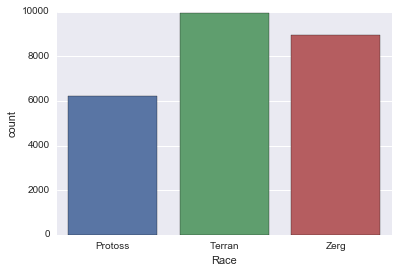

In [23]:
hue_order = ['Protoss','Terran','Zerg']
ax = sns.countplot(df['Race'])

Looks like Terran is the most popular race, followed closely by Zerg and Protoss trailing quite heavily.  

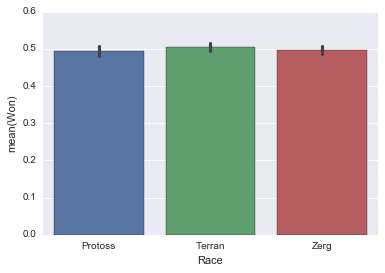

In [24]:
ax = sns.barplot(data=df,x='Race',y='Won')

Terrans being the most popular race is barely justified by their win percentage, but Protoss actually beat our Zerg even though they are less often selected.

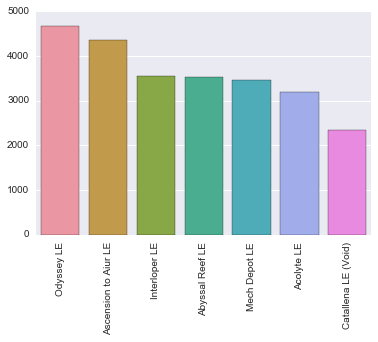

In [25]:
map_counts = df.groupby(by='Map').count()
labels,values = zip(*sorted(map_counts['Won'].items(), key=lambda x:x[1],reverse=True))

ax = sns.barplot(x=labels, y=values)
ax = ax.set_xticklabels(rotation=90,labels = labels)

That's a nice looking linearly decreasing trend in map popularity, with Odyssey being the favorite and Catallena way in last, but this is likely due to Catallena being the only 4 player ladder map, which can cause some extra quirks for players playing 1v1 on it.

In [26]:
map_race_counts = df.groupby(by=['Map','Race']).count()
mr_df = map_race_counts['Won'].reset_index()
maps = set(mr_df['Map'])

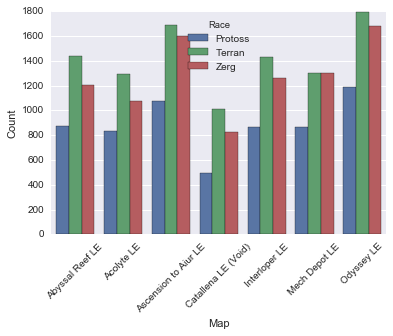

In [27]:
ax = sns.barplot(data=mr_df,x='Map', y='Won', hue='Race',hue_order=hue_order)
ax.set(xlabel='Map', ylabel='Count')
g = plt.xticks(rotation=45)

Protoss seem to especially dislike Catallena, prefering Mech Depot and Ascension to Aiur. Terran and Zerg follow closely the general map popularity trend, with Zerg favouring Odyssey the most. Terrans seem to be the race most willing to play Catallena. 

In [28]:
map_race_win_counts = df.groupby(by=['Map','Race','Won']).count()
mrw_df = map_race_win_counts.reset_index()
mrw_df['Race_Won'] = mrw_df['Race'].astype(str) + mrw_df['Won'].astype(str)
mrw_df

,Map,Race,Won,EnemyRace,ReplayID,Race_Won
0,Abyssal Reef LE,Protoss,False,439,439,ProtossFalse
1,Abyssal Reef LE,Protoss,True,437,437,ProtossTrue
2,Abyssal Reef LE,Terran,False,709,709,TerranFalse
3,Abyssal Reef LE,Terran,True,727,727,TerranTrue
4,Abyssal Reef LE,Zerg,False,614,614,ZergFalse
5,Abyssal Reef LE,Zerg,True,595,595,ZergTrue
6,Acolyte LE,Protoss,False,418,418,ProtossFalse
7,Acolyte LE,Protoss,True,416,416,ProtossTrue
8,Acolyte LE,Terran,False,667,667,TerranFalse
9,Acolyte LE,Terran,True,625,625,TerranTrue


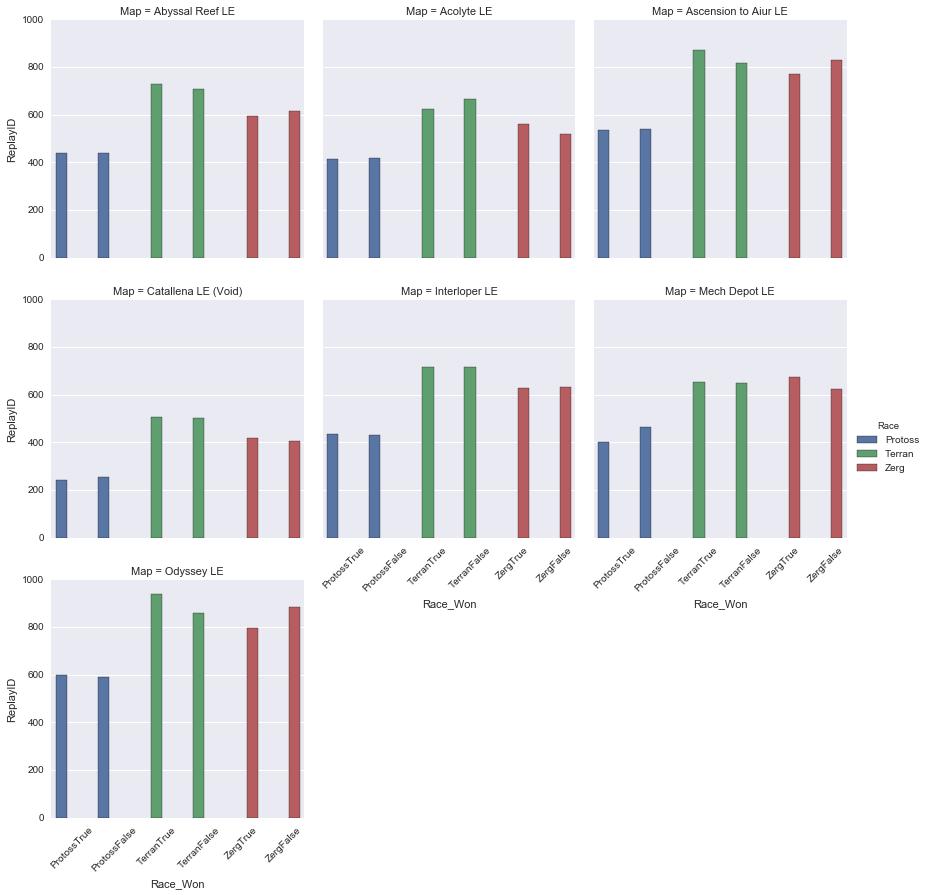

In [29]:
order = ['ProtossTrue','ProtossFalse', 'TerranTrue','TerranFalse', 'ZergTrue','ZergFalse']
fg = sns.factorplot(x='Race_Won', y='ReplayID', hue='Race', 
                        col='Map', data=mrw_df, kind='bar',
                   col_wrap=3,order=order,hue_order=hue_order)
for ax in fg.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

Protoss avoiding Catallena might not be the best choice as they have a positive win rate on that map, with only zerg having more losses then wins on it, but Protoss might be focusing their efforts in trying to play Ascension to Aiur as that's where they have the best win rate (how fitting!). Here's a summary of the best and worst map for each race with winrates.

<b>Protoss</b>  
Best Map - Ascension to Aiur (54%)  
Worst Map - Mech Depot (45%)  

<b>Terran</b>  
Best Map - Mech Depot (56%)  
Worst Map - Interloper (47%)  

<b>

<h2>Build Orders and Winrates</h2>
Enough game meta, lets see what we can pull out from the build order data from the various replays

In [30]:
#grab only the firendly build order, filter out the enemies, keep won flag
all_friendly_builds = [[tuple([unit for unit in build[0] if unit[-1] == '0']),build[1]] for build in all_builds]
all_friendly_builds[0]

[('Nexus0',
  'Probe0',
  'Pylon0',
  'Gateway0',
  'Assimilator0',
  'CyberneticsCore0',
  'Stargate0',
  'Adept0',
  'AdeptPhaseShift0',
  'Oracle0',
  'WarpGate0',
  'Zealot0',
  'Sentry0',
  'TwilightCouncil0',
  'Forge0',
  'MothershipCore0',
  'Phoenix0',
  'RoboticsFacility0',
  'OracleStasisTrap0',
  'TemplarArchive0',
  'PhotonCannon0',
  'Observer0',
  'WarpPrism0',
  'HighTemplar0',
  'Immortal0',
  'Archon0',
  'WarpPrismPhasing0',
  'Stalker0'),
 False]

Max build length = 51
Average build length = 23


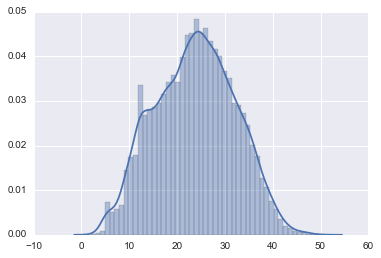

In [31]:
build_lengths = [len(bld[0]) for bld in all_friendly_builds]
max_build_len = max(build_lengths)
avg_build_len = np.mean(build_lengths)
print("Max build length = %s" %(max_build_len))
print("Average build length = %s" %int(avg_build_len))
g = sns.distplot(build_lengths,bins=50)

The length of a players build, ie the number of unique units in their tech tree, is a real nice normal distribution, with most games lasting between 20-30 unique buildings and units, tailing off into shorter and longer games up to a max of 49 unique units. There's a pretty big spike at the 12 unit mark, lets see if we can find what's causing that.

The script below can sort out the most common build orders at various stages of a game, and find the builds with the most wins.

In [32]:
from collections import Counter
def common_builds(all_builds,build_start,len_build,winner=None,n_top=10):
    if winner != None:
        winning_rates = []
        winning_builds = Counter([build[0][build_start:min(len(build[0]),build_start + len_build +1)]
                  for build in all_builds
                  if build[1] == True])
        losing_builds = Counter([build[0][build_start:min(len(build[0]),build_start + len_build +1)]
                  for build in all_builds
                  if build[1] == False])
        for build in set(winning_builds).union(set(losing_builds)):
            if build in winning_builds:
                wins = winning_builds[build]
                
            else:
                wins = 0
            if build in losing_builds:
                loses = losing_builds[build]
            else:
                loses = 0
            win_rate = (wins/(wins+loses))
            winning_rates.append([build,win_rate,wins])
        return sorted(winning_rates,key=lambda x:(x[2],x[1]),reverse=winner)[0:n_top]
    else:
        builds = Counter([build[0][build_start:min(len(build[0]),build_start + len_build +1)]
                  for build in all_builds])
        return builds.most_common(n_top)

Lets take a look at the spike at tech trees of length 12.

In [43]:
builds = Counter([tuple(build[0]) for build in all_friendly_builds if len(build[0]) == 12])
cmn_builds = builds.most_common(3)
for bld in cmn_builds:
    print(bld)
    print("")

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'Queen0', 'BanelingNest0', 'BanelingCocoon0', 'Baneling0'), 120)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'BanelingNest0', 'Queen0', 'BanelingCocoon0', 'Baneling0'), 106)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'SpawningPool0', 'Extractor0', 'Zergling0', 'Queen0', 'BanelingNest0', 'BanelingCocoon0', 'Baneling0'), 43)



In [34]:
cmn_builds = common_builds(all_friendly_builds,0,max_build_len,n_top=10)
for bld in cmn_builds:
    print(bld)
    print("")

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'Queen0', 'BanelingNest0', 'BanelingCocoon0', 'Baneling0'), 120)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'Queen0'), 108)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'BanelingNest0', 'Queen0', 'BanelingCocoon0', 'Baneling0'), 106)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'SpawningPool0', 'Extractor0', 'Zergling0', 'Queen0', 'BanelingNest0', 'BanelingCocoon0', 'Baneling0'), 43)

(('Nexus0', 'Probe0', 'Pylon0', 'Forge0', 'PhotonCannon0'), 39)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'BanelingNest0', 'Zergling0', 'Queen0', 'BanelingCocoon0', 'Baneling0'), 31)

(('Hatchery0', 'Drone0', 'Overlord0', 'Larva0', 'Egg0', 'Extractor0', 'SpawningPool0', 'Zergling0', 'Queen0', 'BanelingNest0'), 29)

(('CommandCenter0', 'SC

In [ ]:
cmn_builds = common_builds(all_friendly_builds,0,6,n_top=10)
for bld in cmn_builds:
    print(bld)
    print("")

In [ ]:
cmn_builds = common_builds(all_friendly_builds,0,max_build_len,winner=True, n_top=10)
for bld in cmn_builds:
    print(bld)
    print("")

In [ ]:
cmn_builds = common_builds(all_friendly_builds,0,6,winner=True, n_top=10)
for bld in cmn_builds:
    print(bld)
    print("")

<h2>Build Order Sequence Predictor</h2>

In [46]:
builder = BuildRecommender("replay_state_data",'build_orders.json')
pop = builder.evolve(6,0.4,0.2,3)

Training Step: 27998  | total loss: 5.39115 | time: 95.487s
| Adam | epoch: 031 | loss: 5.39115 -- iter: 016384/118861
Successfully left training! Final model loss: None


KeyboardInterrupt: 

In [49]:
builder = BuildRecommender("replay_state_data",'build_orders.json')
#builder.save_all_build_orders()
load_blds = builder.load_all_build_orders()
builder.load_graph()
rec_build = builder.predict_build(['CommandCenter0'],20,races=['Terran','Zerg'])

Scratch Pad:  
Predictive model - build orders  
GA for hyperparameter tuning  
Seperate build order models for RvR  
Predictive model of win prob given build order  
Use win predictor for optimal build order planning algo  
Incorporate patch stats to learn meta evolution and predict best builds for new metas  
Race per map  
Race win per map  
race vs race wins  
best vs worst builds 
visualize disparity between good and bad builds  
predict optimal path for each race vs each race (can limit predictions for enemy race)  
avg game build length  
Visualization of tech tree and recommended path  

TODO:  
EA Optimization  
Documentation 
EDA Analysis  
Comment Code  
Visualization  
Webapp  
Blog post